<a href="https://colab.research.google.com/github/nurkayevaa/holidays/blob/master/santa_not_santa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("/content/drive/My Drive/")


In [0]:
data_dir = 'images'
batch_size = 64

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [5]:
model = models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:01<00:00, 23.4MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [0]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model.to(device);

In [0]:
import pandas as pd

In [8]:
epochs = 10
steps = 0
running_loss = 0
print_every = 5
train_stats = pd.DataFrame(columns = ['Epoch',  'Train loss',
                                      'Test loss'])
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            train_stats = train_stats.append({'Epoch': epoch, 
                                              'Train loss' : running_loss/len(trainloader),
                                     'Test loss' : test_loss/len(testloader)}, ignore_index=True)
            running_loss = 0
            model.train()

Epoch 1/10.. Train loss: 0.599.. Test loss: 0.385.. Test accuracy: 0.953
Epoch 2/10.. Train loss: 0.339.. Test loss: 0.209.. Test accuracy: 0.910
Epoch 2/10.. Train loss: 0.180.. Test loss: 0.098.. Test accuracy: 0.977
Epoch 3/10.. Train loss: 0.100.. Test loss: 0.086.. Test accuracy: 0.965
Epoch 4/10.. Train loss: 0.086.. Test loss: 0.047.. Test accuracy: 0.987
Epoch 4/10.. Train loss: 0.075.. Test loss: 0.064.. Test accuracy: 0.973
Epoch 5/10.. Train loss: 0.049.. Test loss: 0.037.. Test accuracy: 0.983
Epoch 5/10.. Train loss: 0.062.. Test loss: 0.051.. Test accuracy: 0.980
Epoch 6/10.. Train loss: 0.038.. Test loss: 0.028.. Test accuracy: 0.996
Epoch 7/10.. Train loss: 0.029.. Test loss: 0.029.. Test accuracy: 0.983
Epoch 7/10.. Train loss: 0.033.. Test loss: 0.039.. Test accuracy: 0.992
Epoch 8/10.. Train loss: 0.023.. Test loss: 0.023.. Test accuracy: 0.992
Epoch 9/10.. Train loss: 0.029.. Test loss: 0.022.. Test accuracy: 0.992
Epoch 9/10.. Train loss: 0.027.. Test loss: 0.019..

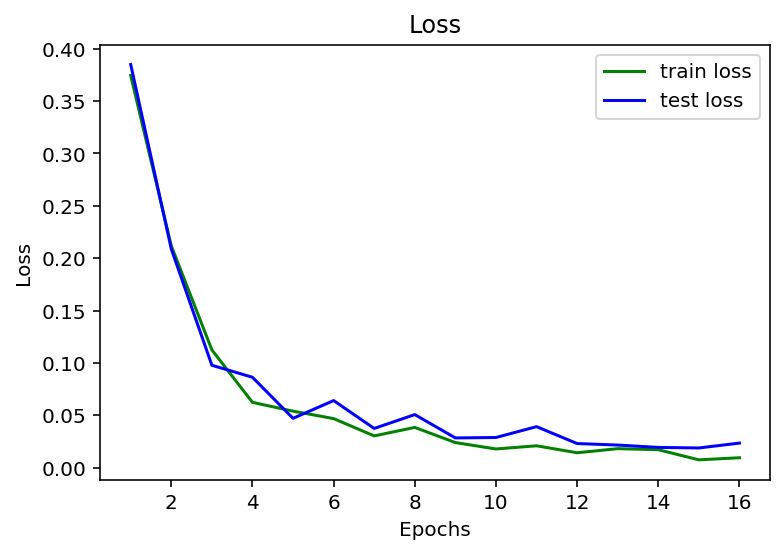

In [9]:
import numpy as np
import matplotlib.pyplot as plt

ax = plt.axes()

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss");

x = range(1, len(train_stats['Train loss'].values) + 1)
ax.plot(x, train_stats['Train loss'].values, '-g', label='train loss');
ax.plot(x, train_stats['Test loss'].values, '-b', label='test loss');

plt.legend()
plt.show()

In [0]:
def view_classify(img, ps, title):
    """
    Function for viewing an image and it's predicted classes
    with matplotlib.

    INPUT:
        img - (tensor) image file
        ps - (tensor) predicted probabilities for each class
        title - (str) string with true label
    """
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    image = img.permute(1, 2, 0)
    
    ax2.imshow(image.numpy())
    ax2.axis('off')
    
    ax1.barh(np.arange(2), ps)
    ax1.set_aspect(0.1)
    ax1.set_yticks(np.arange(2))
    ax1.set_yticklabels(list(classes_dict.values()));
    ax1.set_title(title)
    ax1.set_xlim(0, 1.1)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


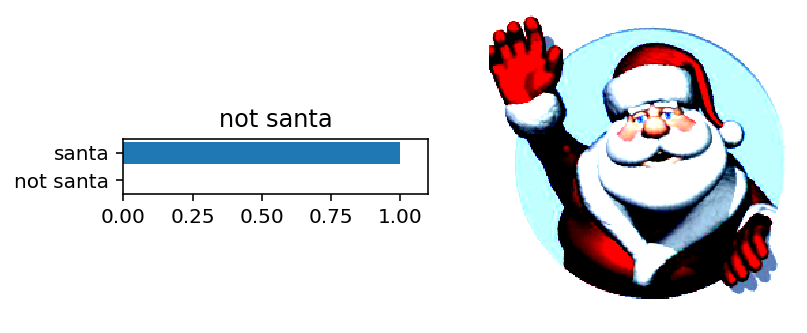

In [20]:
classes_dict = {
    1:'not santa',
    0:'santa'
    
}

for batch_idx, (inputs, labels) in enumerate(trainloader):
    inputs, labels = inputs.to(device), labels.to(device)
    img = inputs[0]
    label_true = labels[0]
    ps = model(inputs)
    view_classify(img.cpu(), torch.softmax(ps[0].cpu(), dim=0), classes_dict[int(label_true.cpu().numpy())])
      
    break;

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


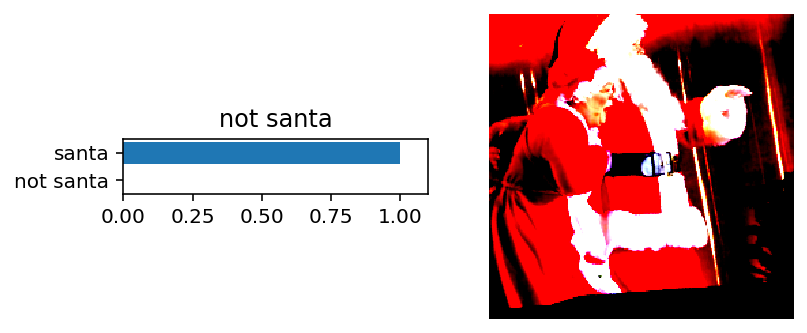

In [21]:
classes_dict = {
    1:'not santa',
    0:'santa'
    
}

for batch_idx, (inputs, labels) in enumerate(trainloader):
    inputs, labels = inputs.to(device), labels.to(device)
    img = inputs[0]
    label_true = labels[0]
    ps = model(inputs)
    view_classify(img.cpu(), torch.softmax(ps[0].cpu(), dim=0), classes_dict[int(label_true.cpu().numpy())])
      
    break;

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


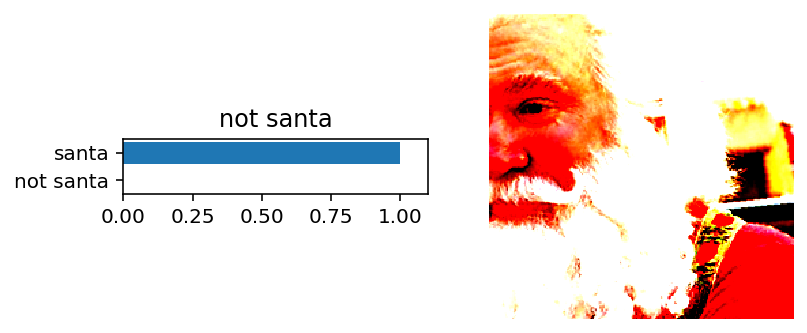

In [22]:
classes_dict = {
    1:'not santa',
    0:'santa'
    
}

for batch_idx, (inputs, labels) in enumerate(trainloader):
    inputs, labels = inputs.to(device), labels.to(device)
    img = inputs[0]
    label_true = labels[0]
    ps = model(inputs)
    view_classify(img.cpu(), torch.softmax(ps[0].cpu(), dim=0), classes_dict[int(label_true.cpu().numpy())])
      
    break;

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


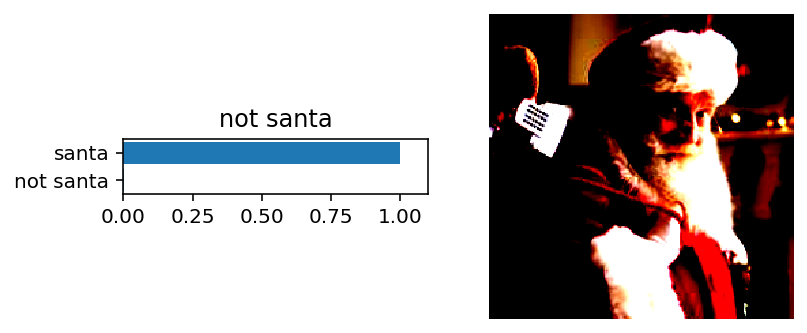

In [23]:
classes_dict = {
    1:'not santa',
    0:'santa'
    
}

for batch_idx, (inputs, labels) in enumerate(trainloader):
    inputs, labels = inputs.to(device), labels.to(device)
    img = inputs[0]
    label_true = labels[0]
    ps = model(inputs)
    view_classify(img.cpu(), torch.softmax(ps[0].cpu(), dim=0), classes_dict[int(label_true.cpu().numpy())])
      
    break;

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


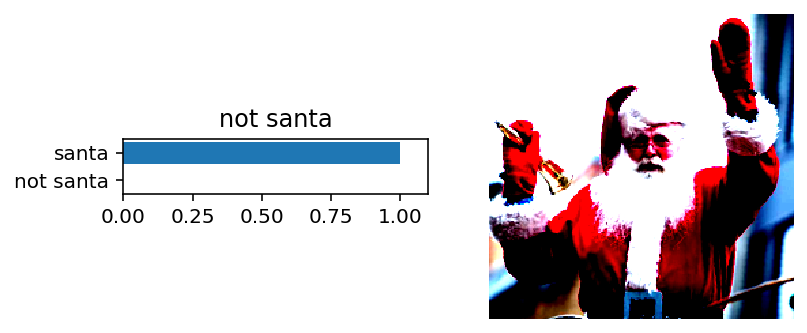

In [24]:
classes_dict = {
    1:'not santa',
    0:'santa'
    
}

for batch_idx, (inputs, labels) in enumerate(trainloader):
    inputs, labels = inputs.to(device), labels.to(device)
    img = inputs[0]
    label_true = labels[0]
    ps = model(inputs)
    view_classify(img.cpu(), torch.softmax(ps[0].cpu(), dim=0), classes_dict[int(label_true.cpu().numpy())])
      
    break;